In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

# Loading dataset for Text Generation

In [47]:
import pandas as pd

df = pd.read_csv("./data.csv")
test = pd.DataFrame(df['Sentence'])
test = test.dropna()
test.head()

,Sentence
0,"""The sun is shining."""
1,"""I enjoy reading books."""
2,"""This pizza tastes amazing."""
3,"""My favorite color is green."""
4,"""I like to play the guitar."""


# Loading text generation models from Hugging Face

In [53]:
from transformers import pipeline

model1= pipeline('text-generation', model='gpt2')
model2= pipeline('text-generation', model='distilgpt2')
model3= pipeline('text-generation', model='gpt2-medium')
model4= pipeline('text-generation', model='gpt2-large')

In [54]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

# Calculating parameters for assessing text generation models -
* ### Perplexity
* ### Rouge score
* ### Bleu score

In [55]:
A=[]
B=[]
C=[]

In [50]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yashas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [56]:
def calculate_perplexity(model, tokenizer, text):
    input_ids = tokenizer.encode(text, return_tensors="pt")
    with torch.no_grad():
        logits = model(input_ids).logits
    loss = torch.nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), input_ids.view(-1))
    perplexity = torch.exp(loss)
    return perplexity.item()

test_data = test['Sentence'].tolist()

In [57]:
for model_name in ["gpt2", "distilgpt2", "gpt2-medium", "gpt2-large"]:
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name)

    total_perplexity = 0
    total_bleu_score = 0
    total_rouge_score = 0

    for sentence in test_data:
        sentence = str(sentence)

        tokens = tokenizer.tokenize(sentence)
        perplexity_score = calculate_perplexity(model, tokenizer, tokens)
        total_perplexity += perplexity_score

        reference_tokens = [nltk.word_tokenize(sentence.lower())]
        candidate_tokens = tokenizer.tokenize(sentence)
        bleu_score = sentence_bleu(reference_tokens, candidate_tokens)
        total_bleu_score += bleu_score

        scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
        scores = scorer.score(sentence, sentence)
        rouge_score = scores['rougeL'].fmeasure
        total_rouge_score += rouge_score

    avg_perplexity = total_perplexity / len(test_data)
    avg_bleu_score = total_bleu_score / len(test_data)
    avg_rouge_score = total_rouge_score / len(test_data)

    print(f"Model: {model_name}")
    print(f"Avg Perplexity: {avg_perplexity}")
    A.append(avg_perplexity)
    print(f"Avg BLEU Score: {avg_bleu_score}")
    B.append(avg_bleu_score)
    print(f"Avg ROUGE Score: {avg_rouge_score}")
    C.append(avg_rouge_score)
    print("\n")

C:\Users\Yashas\Desktop\Topsis-text-generation\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Yashas\Desktop\Topsis-text-generation\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Yashas\Desktop\Topsis-text-generation\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Con

Model: gpt2
Avg Perplexity: 18263.19857096354
Avg BLEU Score: 8.787765354793972e-233
Avg ROUGE Score: 1.0


Model: distilgpt2
Avg Perplexity: 9102.073893229166
Avg BLEU Score: 8.787765354793972e-233
Avg ROUGE Score: 1.0


Model: gpt2-medium
Avg Perplexity: 19878.61232421875
Avg BLEU Score: 8.787765354793972e-233
Avg ROUGE Score: 1.0


Model: gpt2-large
Avg Perplexity: 26192.336119791667
Avg BLEU Score: 8.787765354793972e-233
Avg ROUGE Score: 1.0




In [58]:
models=['gpt2','distilgpt2','gpt2-medium','gpt2-large']

In [62]:
model_df=pd.DataFrame({'model':models,"perplexity":A,"BLEU":B,"ROUGE":C})

In [68]:
model_df

,perplexity,BLEU,ROUGE
model,,,
gpt2,18263.198571,8.787765e-233,1.0
distilgpt2,9102.073893,8.787765e-233,1.0
gpt2-medium,19878.612324,8.787765e-233,1.0
gpt2-large,26192.336120,8.787765e-233,1.0


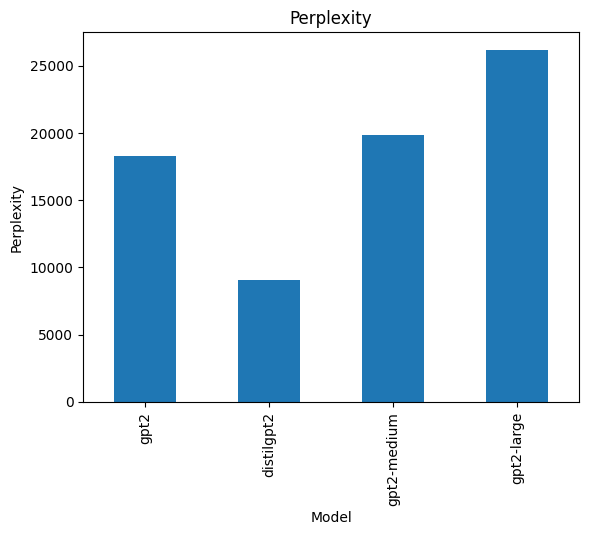

In [81]:
import matplotlib.pyplot as plt

model_df.plot(kind='bar', y='perplexity', legend=False)

plt.xlabel('Model')
plt.ylabel('Perplexity')
plt.title('Perplexity')

plt.show()

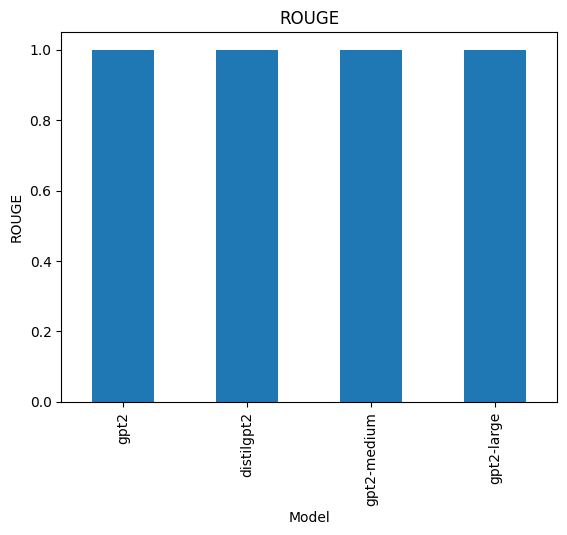

In [83]:
model_df.plot(kind='bar', y='ROUGE', legend=False)

plt.xlabel('Model')
plt.ylabel('ROUGE')
plt.title('ROUGE')

plt.show()

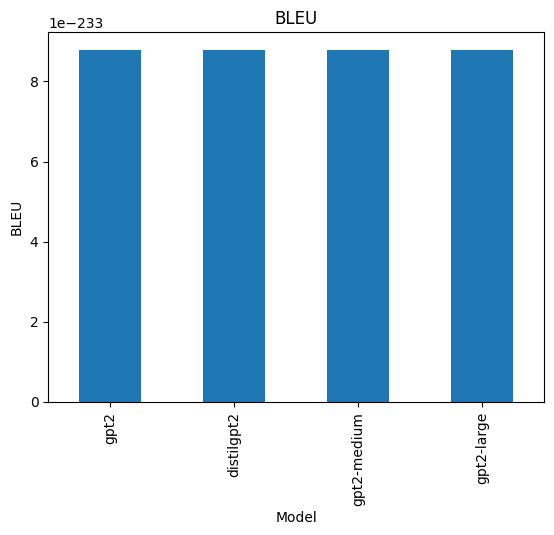

In [84]:
model_df.plot(kind='bar', y='BLEU', legend=False)

plt.xlabel('Model')
plt.ylabel('BLEU')
plt.title('BLEU')

plt.show()

## Topsis Analysis for ranking the models

In [71]:
import pandas as pd
import numpy as np

def topsis():

    data = model_df
    weights = [1,1,1]
    impact = [-1,1,1]

    norm_data=data/np.sqrt((data ** 2).sum(axis=0))
    norm_data=norm_data*weights
    rough=norm_data*impact


    best=rough.max().abs()
    worst=rough.min().abs()
    dist_best=np.sqrt(((norm_data-best)**2).sum(axis=1))
    dist_worst=np.sqrt(((norm_data-worst)**2).sum(axis=1))


    total_dist=dist_best+dist_worst
    performance=dist_worst/total_dist
    rank = pd.Series(performance, name='Performance').rank(ascending=False).astype(int)

    norm_data['TopsisScore']=performance
    norm_data['Rank']=rank
    
    return norm_data

topsis_analysis = topsis()
topsis_analysis

,perplexity,BLEU,ROUGE,TopsisScore,Rank
model,,,,,
gpt2,0.471933,inf,0.5,0.463956,2
distilgpt2,0.235204,inf,0.5,1.000000,1
gpt2-medium,0.513676,inf,0.5,0.369434,3
gpt2-large,0.676827,inf,0.5,0.000000,4
